# Introductory applied machine learning (INFR10069)

# Assignment 4: Feature Engineering

## Marking Breakdown

**70-100%** results/answer correct plus extra achievement at understanding or analysis of results. Clear explanations, evidence of creative or deeper thought will contribute to a higher grade.

**60-69%** results/answer correct or nearly correct and well explained.

**50-59%** results/answer in right direction but significant errors.

**40-49%** some evidence that the student has gained some understanding, but not answered the questions
properly.

**0-39%** serious error or slack work.


## Mechanics

You should produce a Jupyter notebook in answer to this assignment.
**You need to submit this notebook electronically as described below.**

Place your notebook in a directory called `iamlans` and submit this directory using the submit command on a DICE machine. The format is:

`submit iaml 4 iamlans`

You can check the status of your submissions with the `show_submissions` command.

**Late submissions:** The policy stated in the School of Informatics MSc Degree Guide is that normally you will not be allowed to submit coursework late. See http://www.inf.ed.ac.uk/teaching/years/msc/courseguide10.html#exam for exceptions to this, e.g. in case of serious medical illness or serious personal problems.

**Collaboration:** You may discuss the assignment with your colleagues, provided that the writing that you submit is entirely your own. That is, you should NOT borrow actual text or code from other students. We ask that you provide a list of the people who you've had discussions with (if any).

## Important Instructions

1. In the following questions you are asked to run experiments using Python (version 2.7) and the following packages:
    * Numpy
    * Pandas
    * Scikit-learn 0.17
    * Matplotlib
    * Seaborn

2. Before you start make sure you have set up a vitual environment (or conda environment if you are working on your own machine) and the required packages installed. Instructions on how to set-up the working enviornment and install the required packages can be found in `01_Lab_1_Introduction`.

3. Wherever you are required to produce code you should use code cells, otherwise you should use markdown cells to report results and explain answers. **You are welcome to split your answer into multiple cells with intermediate printing.**

4. The .csv files that you will be using are located at `./datasets` (the `datasets` directory is adjacent to this file).

5. **IMPORTANT:** Keep your answers brief and concise. Most questions can be answered with 2-3 lines of explanation (excluding coding questions), unless stated otherwise.

## Imports

In this assignment you are asked to import all the packages and modules you will need. Include all required imports and execute the cell below.

In [37]:
from __future__ import print_function, division
%matplotlib inline

In [38]:
# Your code goes here
import os
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score,confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import KFold, cross_val_predict
from sklearn.metrics import log_loss

## Description of the datasets


This assignment is based on two datasets:
1. the 20 Newsgroups Dataset (you should recognise it from Assignment 1)
2. the MNIST digits dataset

### 20 Newsgroups

For convenience, we repeat the description here. This dataset is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related to each other (e.g. comp.sys.ibm.pc.hardware, comp.sys.mac.hardware), while others are highly unrelated (e.g misc.forsale, soc.religion.christian). 

To save you time and to make the problem manageable with limited computational resources, we preprocessed the original dataset. We will use documents from only 5 out of the 20 newsgroups, which results in a 5-class problem. More specifically the 5 classes correspond to the following newsgroups: 
1. `alt.atheism`
2. `comp.sys.ibm.pc.hardware`
3. `comp.sys.mac.hardware`
4. `rec.sport.baseball`
5. `rec.sport.hockey `

However, note here that classes 2-3 and 4-5 are rather closely related.

**In contrast to Assignment 1**, we have opted to use tf-idf weights ([term frequency - inverse document frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf))
for each word instead of the frequency counts. These weights represent the importance of a word to a
document with respect to a collection of documents. The importance increases proportionally to the number
of times a word appears in the document and decreases proportionally to the number of times the word
appears in the whole corpus. 

Additionally we preprocess the data to include the most frequent 1000 words that are in greater than 2 documents, less than half of all documents, and that are not [stop words](https://en.wikipedia.org/wiki/Stop_words).

We will perform all this preprocessing for you.


### MNIST
This MNIST Dataset is a collection handwritten digits. The samples are partitioned (nearly) evenly across the 10 different digit classes {0, 1, . . . , 9}. We use a preprocessed version for which the data are $8 \times 8$ pixel images containing one digit each. For further details on how the digits are preprocessed, see the sklearn documentation. The images are grayscale, with each pixel taking values in {0, 1, . . . , 16}, where 0 corresponds to black (weakest intensity) and 16 corresponds to white (strongest intensity). Therefore, the dataset is a N × 64
dimensional matrix where each dimension corresponds to a pixel from the image and N is the number of
images. 

Again, to save you time, we perfom the import for you.

## 1. Clustering the 20 Newsgroups Data [50%]

In part 1 we will cluster the observations in the 20 Newsgroups dataset using the k-means algorithm. Each row of the dataset represents a document with bag of words features. If we were not given the labels for each document (i.e. the newsgroup it came from), clustering could allow us to infer which documents should have the same label. Observing common words within each cluster may allow us to give meaning to these inferred labels too.

First we'll import the data and fit and evaluate k-means with 5 cluster centres. Next, we will try and infer which cluster corresponds with which label. Finally, we will pretend we don't know the number of clusters there should be, as is the normal scenario with large unlabeled data, and investigate the effect of using a different number of cluster centres (i.e. varying `k`).

### ========== Question 1.0 ==========

Run the below cells to import the data. It would be a good idea to understand the code but it's not strictly necessary (see the [sklearn documentation](http://scikit-learn.org/0.17/datasets/index.html#the-20-newsgroups-text-dataset)).

*This may take a wee while as it will download the dataset*

**Do not change any of the code in this question**

In [39]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

cats = ['alt.atheism', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 
        'rec.sport.baseball', 'rec.sport.hockey']
newsgroups_train = fetch_20newsgroups(subset='train', categories=cats, 
                                      remove=('headers', 'footers', 'quotes'))
vectorizer = TfidfVectorizer(max_df=0.5, max_features=1000,
                             min_df=2, stop_words='english', 
                             token_pattern='(?u)\\b[A-z]{2,}\\b')
X_sparse = vectorizer.fit_transform(newsgroups_train.data)
y_num = newsgroups_train.target
X = pd.DataFrame(X_sparse.todense(), columns=vectorizer.get_feature_names())
y = np.array(cats)[y_num]

### ========== Question 1.1 ==========

Perform an initial inspection of the data, X and y (no more than 5 lines of code). Below the code, describe what the data are i.e. what the objects are, and what they represent (fewer than 4 sentences).

In [40]:
# Your code goes here
print (X.info())
print (X.head(5))
print (y[0:5]) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2845 entries, 0 to 2844
Columns: 1000 entries, abc to zone
dtypes: float64(1000)
memory usage: 21.7 MB
None
   abc  ability  able   ac  accept  access  according  acquired  actually  \
0  0.0      0.0   0.0  0.0     0.0     0.0        0.0       0.0       0.0   
1  0.0      0.0   0.0  0.0     0.0     0.0        0.0       0.0       0.0   
2  0.0      0.0   0.0  0.0     0.0     0.0        0.0       0.0       0.0   
3  0.0      0.0   0.0  0.0     0.0     0.0        0.0       0.0       0.0   
4  0.0      0.0   0.0  0.0     0.0     0.0        0.0       0.0       0.0   

   adaptec  ...   written  wrong  yankees  yeah  year  years  yes  york  \
0      0.0  ...       0.0    0.0      0.0   0.0   0.0    0.0  0.0   0.0   
1      0.0  ...       0.0    0.0      0.0   0.0   0.0    0.0  0.0   0.0   
2      0.0  ...       0.0    0.0      0.0   0.0   0.0    0.0  0.0   0.0   
3      0.0  ...       0.0    0.0      0.0   0.0   0.0    0.0  0.0   0.0   
4   

*Your answer goes here*

Our train dataset is a dataframe, consist of 1000 attributes with 2845 instances (or in this particular case, documents). The attributes are words that might appear in a document, and its value is the frequency/count of the word in the respective document.

The training target data is a numerical categories of newsgroup (y_num), which then converted into its respective names to be stored in a new variable, y.

### ========== Question 1.2 ==========

Initialise a [k-means clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) object with 5 clusters. Make sure that you can reproduce your results exactly. *Hint: there is an argument for this*. You need only set two arguments; others can be kept as default. Call the instantiated object `kmeans`. Use the `fit()` method to fit to the training data (X imported above)

In [41]:
# Your code goes here
kmeans = KMeans(n_clusters=5, random_state=1511) 
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1511, tol=0.0001, verbose=0)

### ========== Question 1.3 ==========

Evauate the quality of this fit.

1. Get a feel for the average distance of a data point from the centre: print the mean of the euclidean distances of all data points from the mean data point (in the whole dataset)
1. print the inertia of the model. *Hint: check the properties of the kmeans object*
1. print the adjusted rand index of the model. *Hint: `adjusted_rand_score`*

Below the code: 
1. Define what the inertia and adjusted rand score are (one or two sentences). *Hint: check [sklearn documentation](http://scikit-learn.org/stable/modules/clustering.html)*
1. Comment on the quality of the clustering implied by the adjusted rand score and inertia

The Euclidean distance for n-dimensional space can be find by following formula,
$$d(p,q) = \sqrt{(p_{1}-q_{1})^2 + (p_{2}-q_{2})^{2}+ \cdots+(p_{i}-q_{i})^{2}+\cdots +(p_{n}-q_{n})^{2}}$$

,where in our case, n is the number of attributes (1000)

In [42]:
# Thus to find the distance between a data point to the mean data point
# X.mean() , mean value of each attributes
euclid = np.sqrt(np.sum(np.square(X - X.mean()),axis=1)) 
print ("The mean of the euclidean distances of all data points, from the mean data point : \n{0}".format(euclid.mean()))

The mean of the euclidean distances of all data points, from the mean data point : 
0.954584949852


In [43]:
print ("Inertia: {0}".format(kmeans.inertia_))
print ("Adjusted rand index of the model: {0}".format(adjusted_rand_score(y, kmeans.labels_)))

Inertia: 2593.21013234
Adjusted rand index of the model: 0.234849406141


*Your answer goes here*

Each cluster or population produced by K-means clustering method, will have a point which can be used to represent the population itself (similar to the center of the cluster, or what can be call a centroid). Inertia is the distance between datapoints and their nearest centroid. Inertia also can be described as "the measure of the heterogeneity of a cluster" [1]

Adjusted Rand Index is a function that can be used to measure the similarity between k-means's predicted label with the true/target label.

As for our training, the inertia value shows that our training data spread not too far from its nearest cluster.
The adjusted rand index value is close to 0.0, which implies a poor labelling performance. 

[1] Marie Chavent,Yves Lechevallier.(2006):Empirical Comparison of a Monothetic Divisive Clustering Method with the Ward and K-Means Clustering Methods.Springer-Verlag Berlin · Heidelberg

### ========== Question 1.4 ==========

Print:
1. the number of datapoints with each label
2. the number of datapoints assigned to each cluster. *Hint: you should use the properties of the kmeans object you just fit.* 

Below the code, comment on the distribution of datapoints to cluster centres.

In [44]:
# Your code goes here
label_count = dict((label,y.tolist().count(label)) for label in set(y.tolist()))

output = kmeans.labels_.tolist()
assigned_count = dict((label,output.count(label)) for label in set(output))
print (label_count,"\n")
print (assigned_count)

{'comp.sys.ibm.pc.hardware': 590, 'rec.sport.baseball': 597, 'rec.sport.hockey': 600, 'comp.sys.mac.hardware': 578, 'alt.atheism': 480} 

{0: 646, 1: 993, 2: 363, 3: 626, 4: 217}


*Your answer goes here*

In the original target data, each label have a similar proportion, around 500-600 datapoints. 
However, the datapoints were not evenly distributed to cluster centres, as there is one cluster which has even more datapoints than another.

### ========== Question 1.5 ==========

We can't visualise these cluster centres directly, since they are 1000 dimensional. However, we can at least measure the distance between each centre. Create a distance matrix such that the entry with index (i,j) shows the distance between centre i and j. *Hint: again you should use the properties of the kmeans object you just fit.*

In [45]:
def euclidean_distance(a,b):
    """Calculate the eculidean distance between 2 points, for n-dimensional space .
        Args:
            a,b: n-dimensional array, [n-points, n-features]
            
        Returns:
            array, Euclidean distance between each points 
    """
    return np.sqrt(np.sum(np.square(a-b)))

In [46]:
# Your code goes here
distance_matrix = np.zeros((5,5))
for i in range(kmeans.cluster_centers_.shape[0]):
    for j in range(kmeans.cluster_centers_.shape[0]):
        distance_matrix[i,j] = euclidean_distance(kmeans.cluster_centers_[i],kmeans.cluster_centers_[j])
print (distance_matrix)

[[ 0.          0.19006342  0.28102486  0.28951354  0.32481391]
 [ 0.19006342  0.          0.21990342  0.20388579  0.34442896]
 [ 0.28102486  0.21990342  0.          0.28184891  0.40341245]
 [ 0.28951354  0.20388579  0.28184891  0.          0.40841314]
 [ 0.32481391  0.34442896  0.40341245  0.40841314  0.        ]]


### ========== Question 1.6 ==========

For each cluster centre label, plot the counts of the true labels. The cluster labels are a property of the k-means object, the true labels are contained in `y`. Make sure that you label the plot axes and legend clearly. Below the code, comment on the quality of the fit. *Hint: you can do the main plot (without labels) in one line with seaborn (you're free to do it as you like though!).*

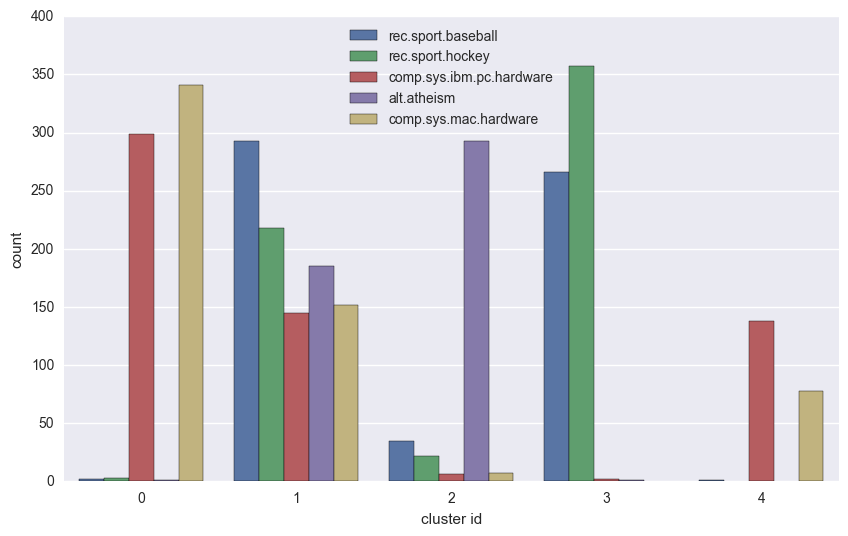

In [47]:
# Your code goes here
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(x=kmeans.labels_,hue=y, ax=ax)
plt.xlabel('cluster id')
plt.show()

*Your answers goes here*

The fit is not impressive. There is only 1 cluster (cluster 2, label alt.atheism) that contain only one main type of datapoints, where the other contain at least 2 main type of datapoints. 

Even more, cluster 0 and 4 main types are exactly the same (label pc hardware & mac hardware). Also, we can not really distinguish one specific label to the other in cluster 1, as their distribution in this cluster are similar.

### ========== Question 1.7 ==========

We will now investigate using dimensionality reduction to try and improve the quality of the fit. Use the sklearn implementation of [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and its method `fit_transform()` to create a reduced reduced dataset for `n_components` = [1,2,3,5,10,20,50,100,500,1000] i.e. create datasets that are of shape `(N, d)` for `d` in `n_components`. Fit k-means to each reduced dataset and report the `inertia` and `adjusted_rand_score` for each iteration.

Plot `adjusted_rand_score` against number of principal components (label graph). Use a log scale on the x axis. Below the graph:
1. describe what it shows
1. explain why we cannot use inertia to choose the best number of principal components
1. explain why dimensionality reduction could help k-means perform better

1
Inertia: 2.82075571925 	 Adj.Rand Index: 0.21097630682 

2
Inertia: 10.5826238098 	 Adj.Rand Index: 0.267448282426 

3
Inertia: 20.4693124792 	 Adj.Rand Index: 0.240086821189 

5
Inertia: 49.4537443604 	 Adj.Rand Index: 0.233241516385 

10
Inertia: 117.676411074 	 Adj.Rand Index: 0.212468360495 

20
Inertia: 230.850680982 	 Adj.Rand Index: 0.203792889905 

50
Inertia: 488.921067969 	 Adj.Rand Index: 0.216163475946 

100
Inertia: 800.774817173 	 Adj.Rand Index: 0.211762954014 

500
Inertia: 2132.01174566 	 Adj.Rand Index: 0.195326468781 

1000
Inertia: 2593.21149232 	 Adj.Rand Index: 0.235951032146 



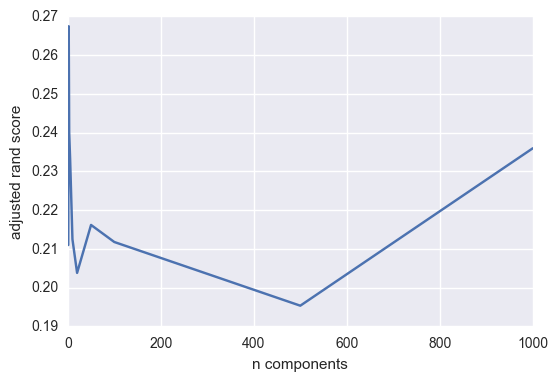

In [48]:
# Your code goes here
n_components = [1,2,3,5,10,20,50,100,500,1000]
rand_idx=[]
for d in n_components:
    print (d)
    pca = PCA(n_components=d,random_state=1511)
    X_trf = pca.fit_transform(X)
    kmeans = KMeans(n_clusters=5, random_state=1511) 
    kmeans.fit(X_trf)
    print("Inertia: {0} \t Adj.Rand Index: {1} \n".format(kmeans.inertia_, adjusted_rand_score(y, kmeans.labels_)))
    rand_idx.append(adjusted_rand_score(y, kmeans.labels_))
    
plt.xlabel('n components')
plt.ylabel('adjusted rand score')
plt.plot(n_components,rand_idx)
plt.show()

*Your answer goes here*
The plot above shows the impact of using more components in Principal Component Analysis, to the adjusted rand score.

In order to determine the best number of principal components, it is more preferable to use the adjusted rand score as a metric rather than inertia, since inertia or the distance of each datapoints to its nearest cluster centres, will definitely be larger in more components.

Dimensionality reduction could help k-means perform better since clustering algorithms mostly use distance as a metric. Dimensionality reduction will preserve that distance, while also help in reducing outliers.

### ========== Question 1.8 ==========

1. So we can visualise the data, create X_2d: the dataset X transformed down to 2 principal component dimensions. Use sklearn's implementation of [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and its method `fit_transform()` to do this (as above). 

1. Create a new k-means object, `kmeans_pca`, and fit the 2d data to it. Show the adjusted rand score.

1. As above, for each cluster centre label, plot the counts of the true labels. The cluster labels are a property of the k-means object, the true labels are contained in `y`. Make sure that you label the plot axes and legend clearly. Print below it the number of data points each cluster is responsible for.

1. Finally, below the plot, comment on the difference between these clusters and the clusters on the 1000 dimensional data with respect to the distribution of the labels in each. Are they better?

Adjusted rand index: 0.235951032146


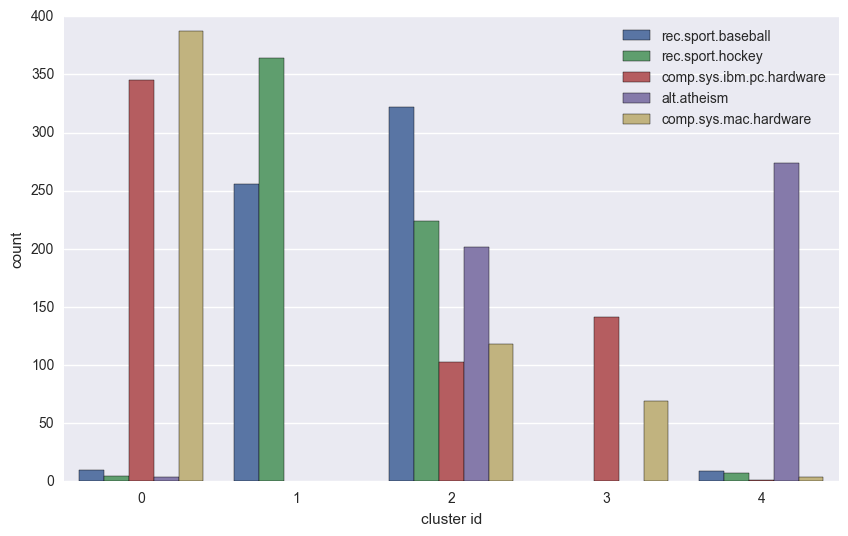

Cluster: 0 , total datapoints: 751
Cluster: 1 , total datapoints: 620
Cluster: 2 , total datapoints: 969
Cluster: 3 , total datapoints: 210
Cluster: 4 , total datapoints: 295


In [49]:
# Your code goes here
pca2 = PCA(n_components=2,random_state=1115)
X_2d = pca2.fit_transform(X)
kmeans_pca = KMeans(n_clusters=5, random_state=1115) 
kmeans_pca.fit(X_2d)
print ("Adjusted rand index: {0}".format(adjusted_rand_score(y, kmeans.labels_)))

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(x=kmeans_pca.labels_, hue=y, ax=ax)
plt.xlabel('cluster id')
plt.show()

prediction = kmeans_pca.labels_.tolist()
assigned_count = dict((label,prediction.count(label)) for label in set(prediction))
for key in assigned_count:
   print ("Cluster: {0} , total datapoints: {1}".format(key, assigned_count[key]))

*Your answer goes here*

The distribution improved slightly, but it still can not distinguish two highly related label, comp.sys.pc.hardware and comp.sys.mac.hardware , which again being two main types of two different cluster.




### ========== Question 1.9 ==========

Given the above plot, apply a label to each cluster centre. Create a new vector, `labels_interp`, which is the same as `kmeans.labels_`, but instead of numbers, the interpreted label of the cluster centre. For example, if you decided cluster 0 was 'apples', 1 was 'pears', 2 was 'stairs', and `kmeans.labels_` was `[2, 0, 1, 1, 0]`, create  `labels_interp = ['stairs', 'apples', 'pears', 'pears', 'apples']`. Hint: an example of how to do this is given in the last line of Question 1.0.

**N.B. be careful to use the `kmeans_pca` object you created above, not the first kmeans object you made**

In [50]:
# Your code goes here
categories = ['comp.sys.mac.hardware','rec.sport.hockey','rec.sport.baseball', 'comp.sys.ibm.pc.hardware','alt.atheism']
labels_interp = np.array(categories)[kmeans.labels_]
print (kmeans.labels_)
print (labels_interp)

[1 3 3 ..., 4 3 3]
['rec.sport.hockey' 'comp.sys.ibm.pc.hardware' 'comp.sys.ibm.pc.hardware'
 ..., 'alt.atheism' 'comp.sys.ibm.pc.hardware' 'comp.sys.ibm.pc.hardware']


### ========== Question 1.10 ==========

Produce a normalised (by true label) confusion matrix of your interpreted labels from the k-means clustering and the true labels. As usual, you may use any functions from previous assignments or labs. Clearly label the axes of the plot. Check that these confusions correlate with your expectations! N.B. this is just a slightly different way of interpreting the information in the count plot above (focussed this time on the true labels).

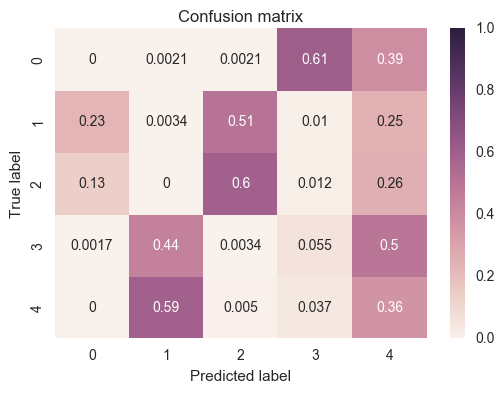

In [51]:
# Your code goes here
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(y, labels_interp)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_norm,classes=[0,1,2,3,4])
plt.show()

### ========== Question 1.11 ==========

Since we are now in 2 dimensions, let's visualise the data, the cluster centres, and the decision boundaries via a [Voronoi_diagram](https://en.wikipedia.org/wiki/Voronoi_diagram). You'll essentially be able to copy and paste the code from the [sklearn kmeans digits example](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) and edit a few bits to get over half marks.

Clearly mark each cluster centre.

For full marks, additionally:
* label each cluster centre with the inferred cluster label
* create a second plot which clearly shows where the true classes lie within the pca space e.g. the [sklearn PCA example here](http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html)

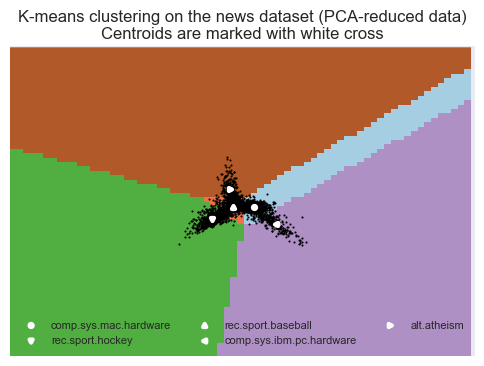

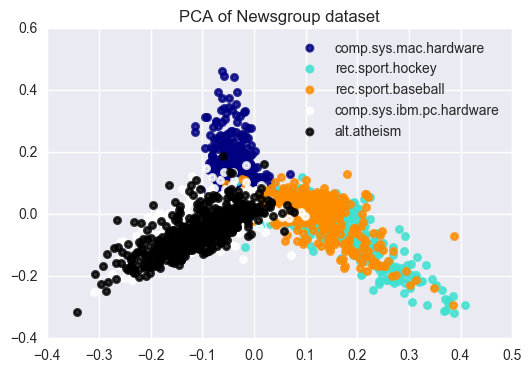

In [52]:
# Your code goes here
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .04   # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans_pca.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(X_2d[:, 0], X_2d[:, 1], 'k.', markersize=3)

# Plot the centroids as a white X
centroids = kmeans_pca.cluster_centers_
mh = plt.scatter(centroids[0, 0], centroids[0, 1],
                marker=matplotlib.markers.MarkerStyle.filled_markers[0], s=5, linewidths=3,
                color='w', zorder=10)
hk = plt.scatter(centroids[1, 0], centroids[1, 1],
                marker=matplotlib.markers.MarkerStyle.filled_markers[1], s=5, linewidths=3,
                color='w', zorder=10)
bb = plt.scatter(centroids[2, 0], centroids[2, 1],
                marker=matplotlib.markers.MarkerStyle.filled_markers[2], s=5, linewidths=3,
                color='w', zorder=10)
ibm = plt.scatter(centroids[3, 0], centroids[3, 1],
                marker=matplotlib.markers.MarkerStyle.filled_markers[3], s=5, linewidths=3,
                color='w', zorder=10)
alt = plt.scatter(centroids[4, 0], centroids[4, 1],
                marker=matplotlib.markers.MarkerStyle.filled_markers[4], s=5, linewidths=3,
                color='w', zorder=10)


plt.legend((mh, hk, bb, ibm, alt),
           tuple(categories),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)

plt.title('K-means clustering on the news dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

plt.figure(2)
colors = ['navy', 'turquoise', 'darkorange','white','black']
lw = 2

for color, i, category in zip(colors, [0, 1, 2, 3, 4], categories):
    plt.scatter(X_2d[y_num==i, 0], X_2d[y_num==i, 1], color=color, alpha=.8, lw=lw,
                label=category)
plt.legend(loc='upper right', shadow=False, scatterpoints=1)
plt.title('PCA of Newsgroup dataset')
plt.show()

### ========== Question 1.12  ==========

*Write a **1 or 2 sentence** answer for each question*.

1. Is the kmeans algorithm deterministic?
1. Did the algorithm you ran above in Question 1.1 do multiple initialisations? If not, explain why it was not necessary. If so, how was the final model selected?
1. The default method for initialising centres in the sklearn implementation is [kmeans++](https://en.wikipedia.org/wiki/K-means%2B%2B). Name another method for initialising and a problem with it.

*Your answer goes here*

Kmeans algorithm is not deterministic, since it will only try to 'group', not to label. Each datapoints will be assigned to a cluster, based on its distance to the nearest centroid.

It didn't do multiple initialisations, since during the process, the centre will be updated. The update will keep going until the number of principal components which have been computed is equal to the original number of variables (thus the final model).

Other similar method for initialising centres for instance, first of three seeding method.

## 2. PCA with MNIST Data [50%]

In the second part of the assignment we will explore the MNIST digits dataset. We expect the digits to lie in a lower-dimensional manifold and want to examine the representation we get by applying Principal Components Analysis (PCA). PCA maps the data into a new space by effectively rotating the base vectors of the input space to the directions with the highest variance. We will assess the impact of this mapping to the classification task and the separability of the data in the PCA space.

### ========== Question 2.0 ==========

Run the cell below to load the digits object and print its description.

**Do not change any of the code in this question**

In [53]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.DESCR)

Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is a

### ========== Question 2.1 ==========

If you execute `digits.keys()`, you'll see this object contains the data, the targets (the labels), and the images (the data reshaped to 8x8 images). More typically the mnist data are [28x28 images](http://yann.lecun.com/exdb/mnist/), but this is a preprocessed version. 

1. Use the pandas describe method on the data to get a feel for the range of each dimension
1. Print the max/min values for each dimension
1. Extract the standard deviations from the output of the describe method (just another DataFrame with 'std' as one of the index values), reshape to an 8x8 image, and plot a heatmap (use `sns.heatmap()`) to show you which dimensions vary the most. For a bonus mark, produce a plot like this for each digit. *Hint: you can use `.groupby(digits.target)` before calling `.describe()`*.
1. Use `sns.heatmap()` to plot the first 9 digits in the dataset

Below the plots:
1. Are all of the dimensions going to be equally helpful for modelling? Explain.

In [54]:
# Your code goes here
data = pd.DataFrame(digits.data)
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,...,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,...,3.725097,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,...,4.919406,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,3.000000,...,7.000000,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,12.000000,2.000000,0.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,2.000000,16.000000,...,16.000000,13.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000


In [55]:
for name in data.columns.values:
    print ("Dimension {0} max value :{1} min value : {2}".format(name,max(data[name]),min(data[name])))

Dimension 0 max value :0.0 min value : 0.0
Dimension 1 max value :8.0 min value : 0.0
Dimension 2 max value :16.0 min value : 0.0
Dimension 3 max value :16.0 min value : 0.0
Dimension 4 max value :16.0 min value : 0.0
Dimension 5 max value :16.0 min value : 0.0
Dimension 6 max value :16.0 min value : 0.0
Dimension 7 max value :15.0 min value : 0.0
Dimension 8 max value :2.0 min value : 0.0
Dimension 9 max value :16.0 min value : 0.0
Dimension 10 max value :16.0 min value : 0.0
Dimension 11 max value :16.0 min value : 0.0
Dimension 12 max value :16.0 min value : 0.0
Dimension 13 max value :16.0 min value : 0.0
Dimension 14 max value :16.0 min value : 0.0
Dimension 15 max value :12.0 min value : 0.0
Dimension 16 max value :2.0 min value : 0.0
Dimension 17 max value :16.0 min value : 0.0
Dimension 18 max value :16.0 min value : 0.0
Dimension 19 max value :16.0 min value : 0.0
Dimension 20 max value :16.0 min value : 0.0
Dimension 21 max value :16.0 min value : 0.0
Dimension 22 max value :

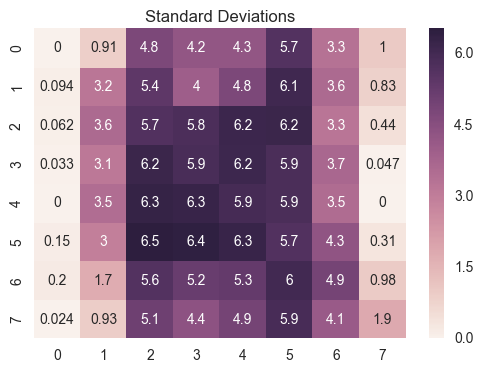

In [56]:
datastd = data.describe().loc['std',:]

sns.heatmap(datastd.values.reshape(8,8),annot=True)
plt.title('Standard Deviations')
plt.show()

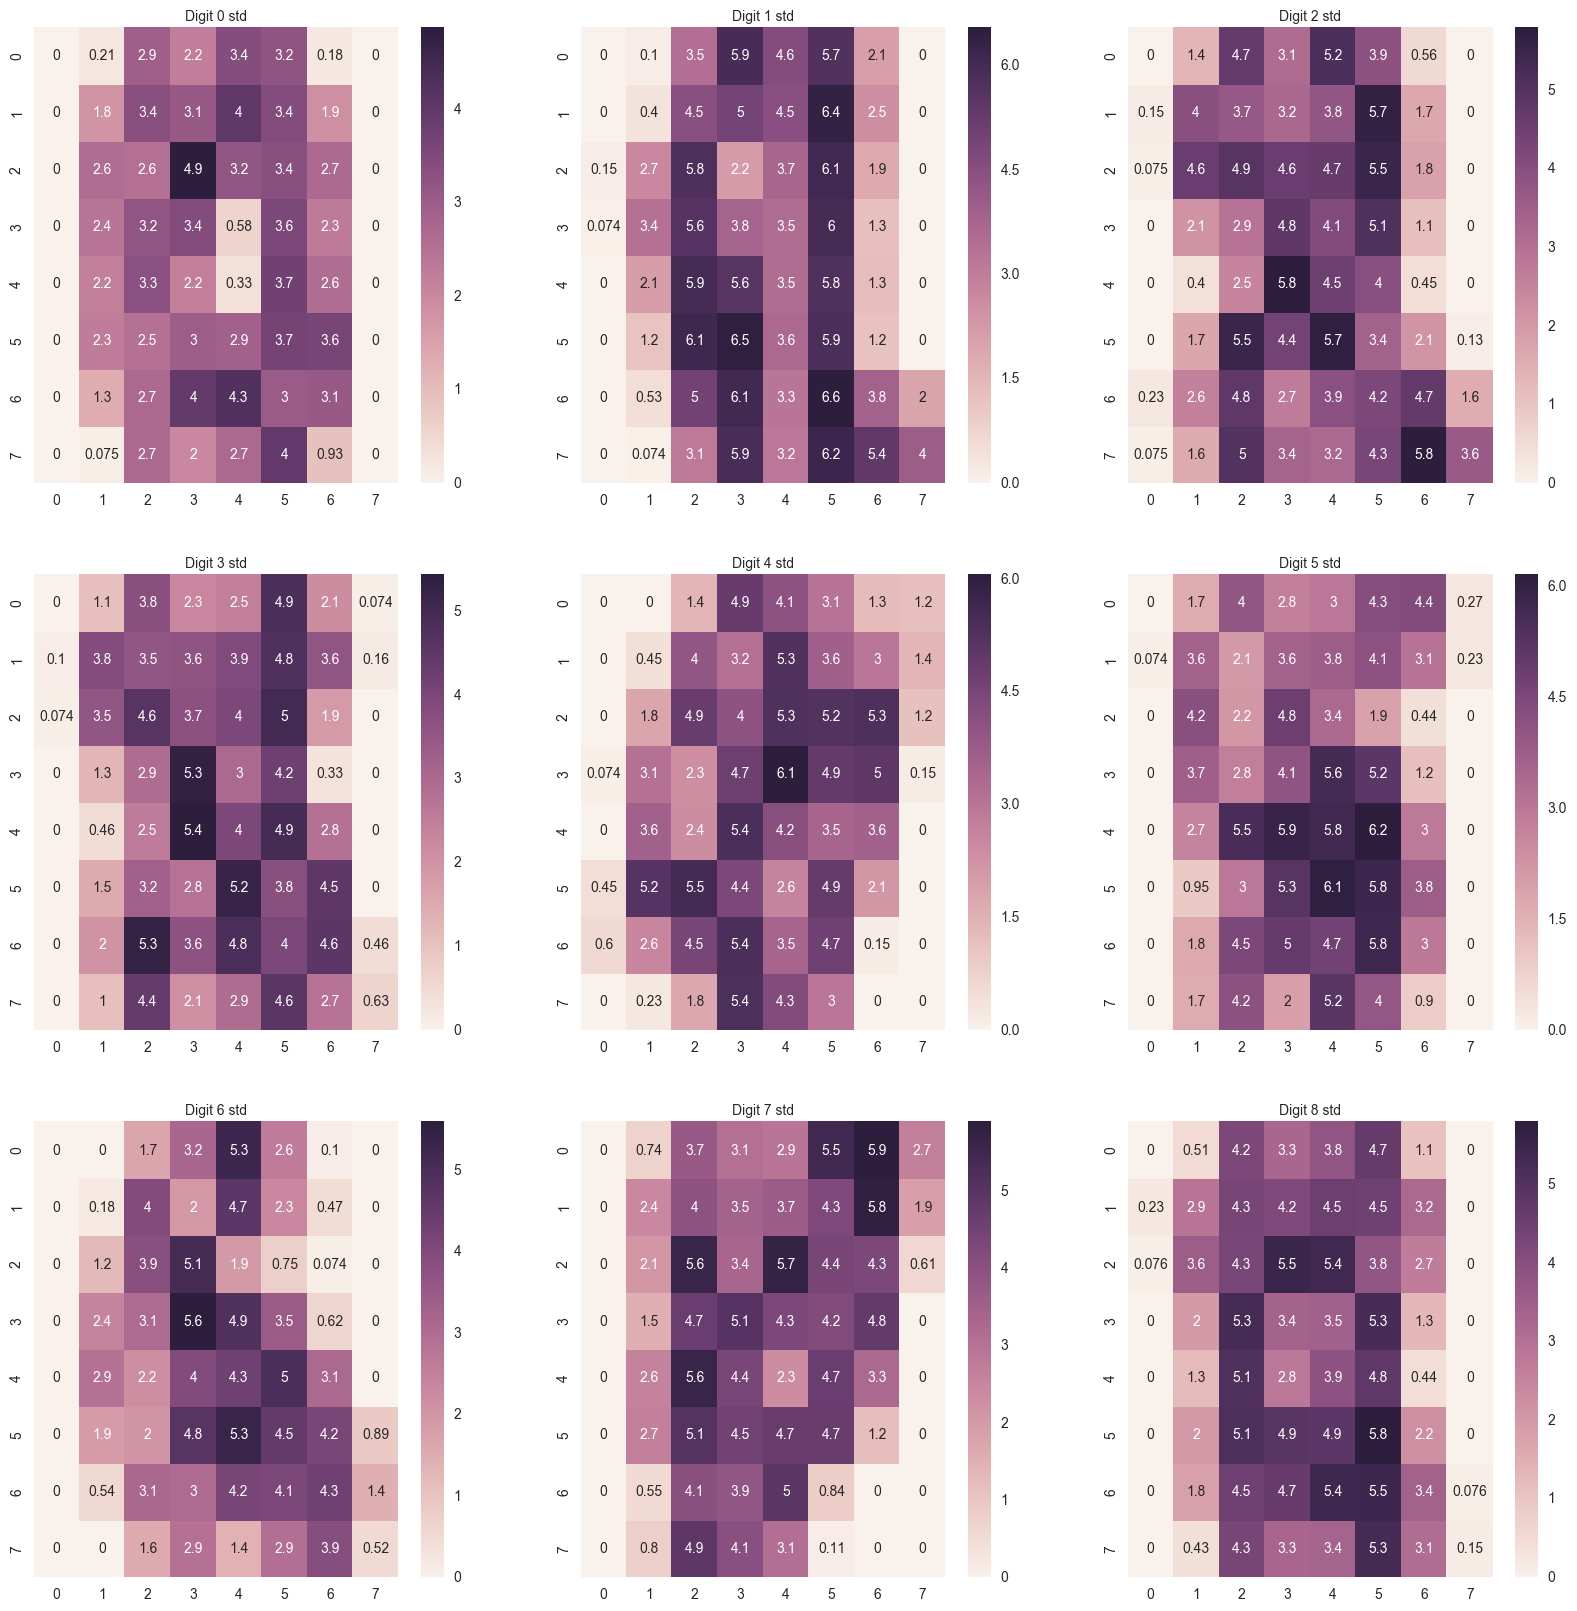

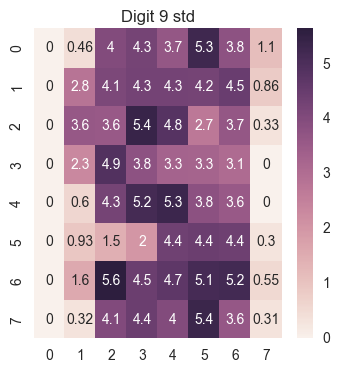

In [57]:
digitsgroup = data.groupby(digits.target).describe()
fig, axs = plt.subplots(nrows=3, ncols=3,figsize=(20, 20))

axs = axs.ravel() #axs reshape to 1D array
for i in range(len(axs)): #axs reshape to 1D array
    axs[i].set_title('Digit '+str(i)+' std',fontsize=10)
    digitstd = digitsgroup.ix[i].loc['std',:]
    axs[i] = sns.heatmap(digitstd.values.reshape(8,8),annot=True,ax=axs[i])
    
# plot the last digit heatmap of standard deviations

plt.figure(2,figsize=(4, 4))
digitstd = digitsgroup.ix[9].loc['std',:]
sns.heatmap(digitstd.values.reshape(8,8),annot=True)
plt.title('Digit 9 std')
plt.show()

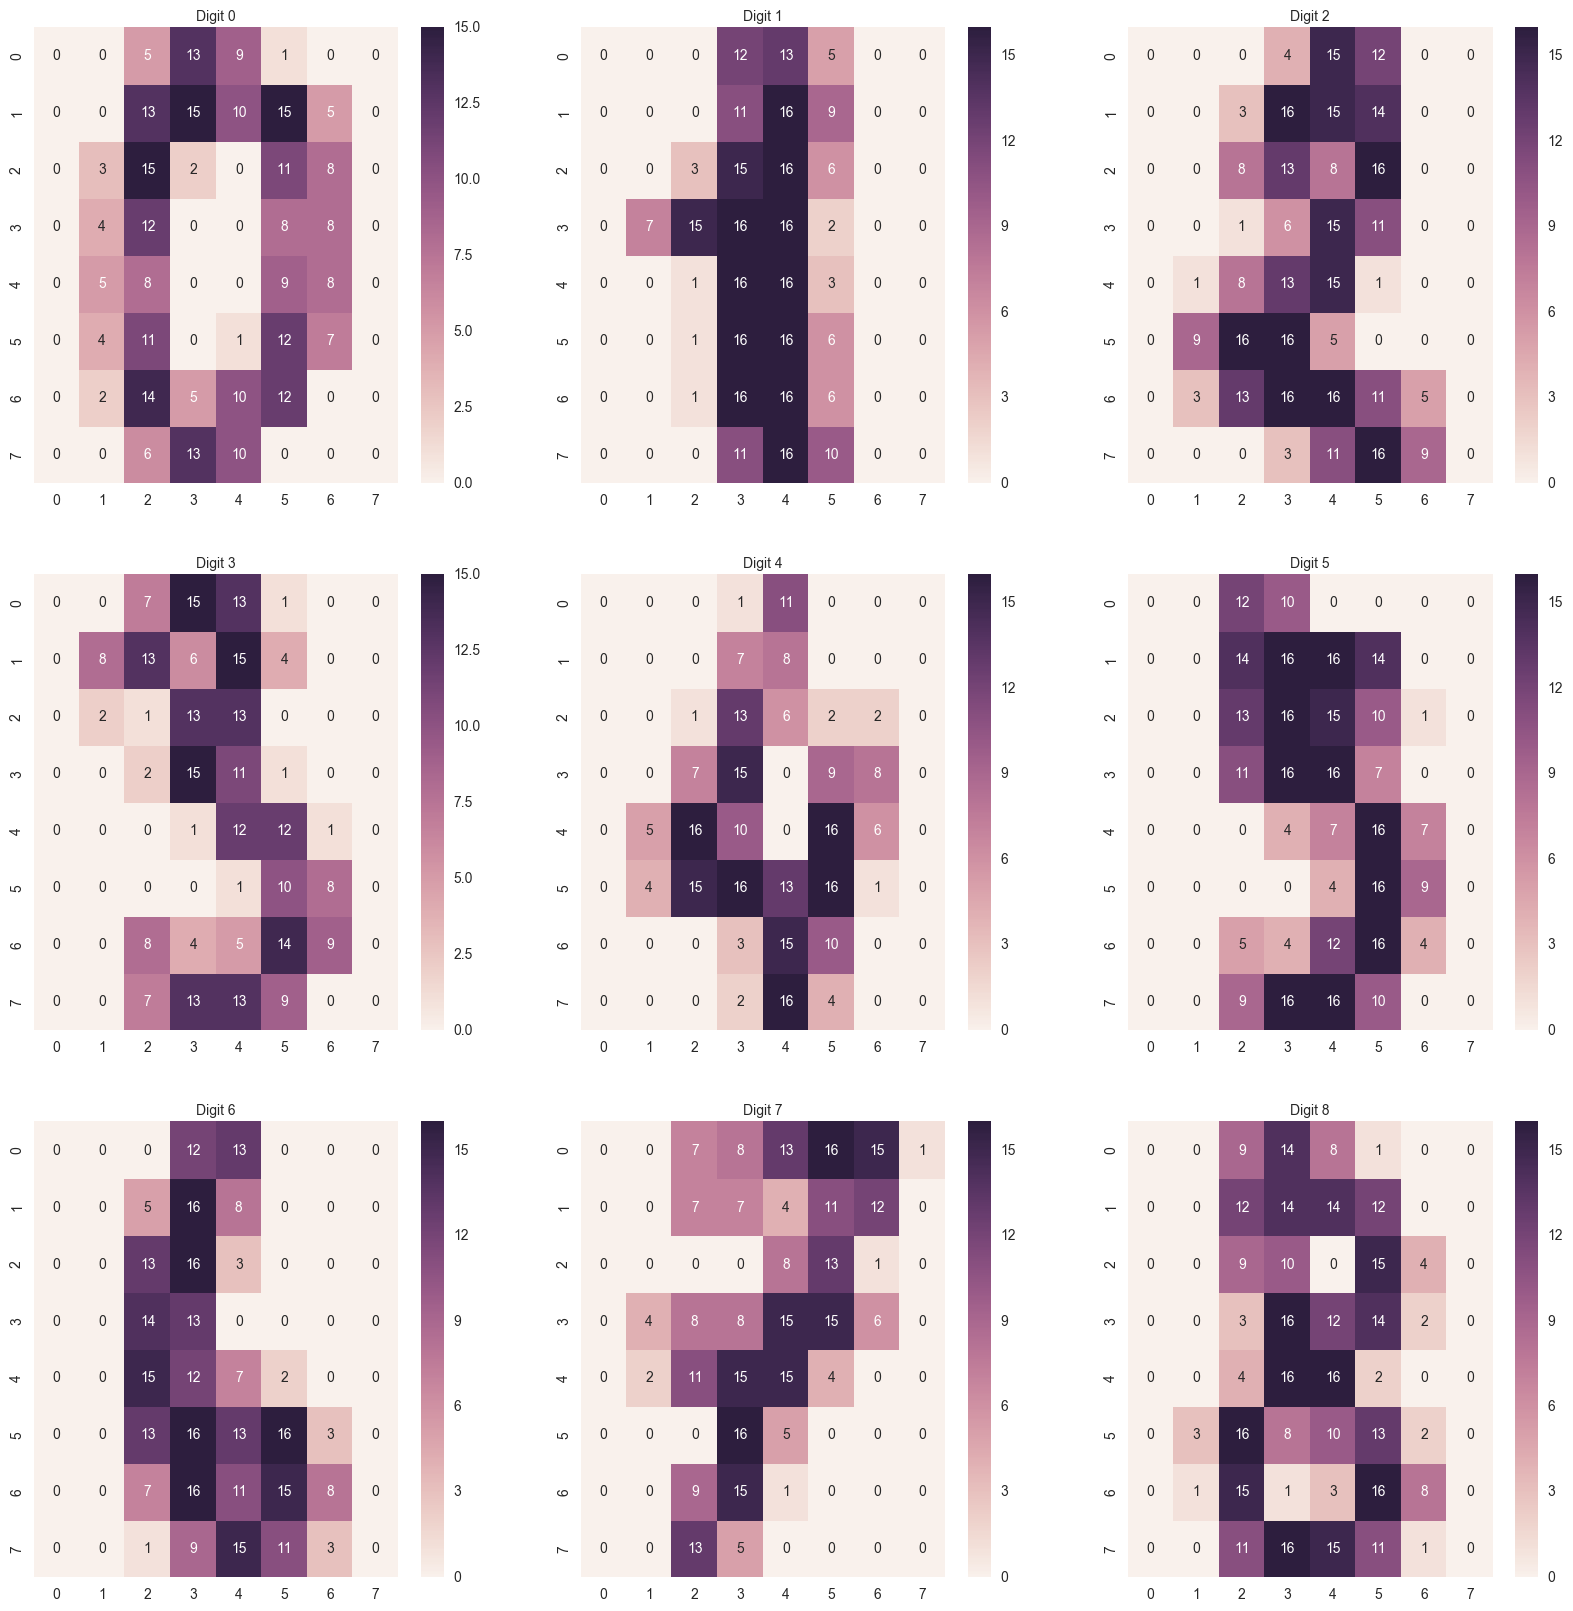

In [58]:
# Use sns.heatmap() to plot the first 9 digits in the dataset

# First 9 digits in the dataset
firstnine = data.head(9)

fig, axs = plt.subplots(nrows=3, ncols=3,figsize=(20, 20))

axs = axs.ravel() #axs reshape to 1D array
for i in range(len(axs)): #axs reshape to 1D array
    axs[i].set_title('Digit '+str(i),fontsize=10)
    plotdigit = firstnine.ix[i]
    axs[i] = sns.heatmap(plotdigit.values.reshape(8,8),annot=True,ax=axs[i])
    

*Your answer goes here*

Not all of the dimensions are going to be helpful for modelling. As we can see, the dimensions near the most-left-side and most-right-side are most likely to have 0 as their value in all of the case (digit 0 to 9).
Thus, the dimensions around the centre will be more helpful for modelling rather than those in both left and right side.

### ========== Question 2.2 ==========

Create a new `PCA` object with `n_components = digits.data.shape[1]`. Plot the explained variance **ratio** against the number of components. You may find [this example](http://scikit-learn.org/stable/auto_examples/plot_digits_pipe.html#sphx-glr-auto-examples-plot-digits-pipe-py) quite handy...

Find the point where 95% of the variance has been explained. Use `plt.vlines()` to add a dotted verical line to the graph at that point and use `plt.annotate()` to label the number of eigenvectors used to explain that variance.

Below the plot, explain what you observe. What does this suggest about the data?

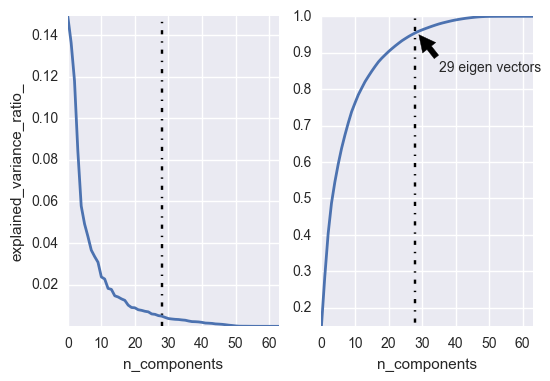

In [59]:
# Your code goes here

n_components = digits.data.shape[1]
pca = PCA(n_components=n_components, random_state=1511)
pca.fit(digits.data)

# visualize
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(pca.explained_variance_ratio_,linewidth=2)
ax1.axis('tight')
ax1.set_xlabel('n_components')
ax1.set_ylabel('explained_variance_ratio_')
ax1.vlines(28,0,1,linestyle='dashdot')

# Find the point where 95% of the variance has been explained
totalvar = 0
idx=[]
plotsum=[]
for i,v in enumerate(pca.explained_variance_ratio_):
    totalvar+=v
    plotsum.append(totalvar)
    if totalvar>=0.95:
        idx.append(i)
    
# print (idx) # idx 28, or n_components 29 already explains 95% of the variance

ax2.plot(plotsum,linewidth=2)
ax2.axis('tight')
ax2.set_xlabel('n_components')
ax2.vlines(28,0,1,linestyle='dashdot')
ax2.annotate('29 eigen vectors', xy=(29, 0.95),xytext=(35, 0.85),arrowprops=dict(facecolor='black', shrink=0.005))
plt.show()

*Your answer goes here*

This suggests that the optimal number of principal components to be used is 29.

### ========== Question 2.3 ==========

You will find the eigenvectors stored within `pca.components_`. Reuse your code from Question 2.1 and plot the first 9 principal components (PCs). Below, plot `pca.mean_`. 

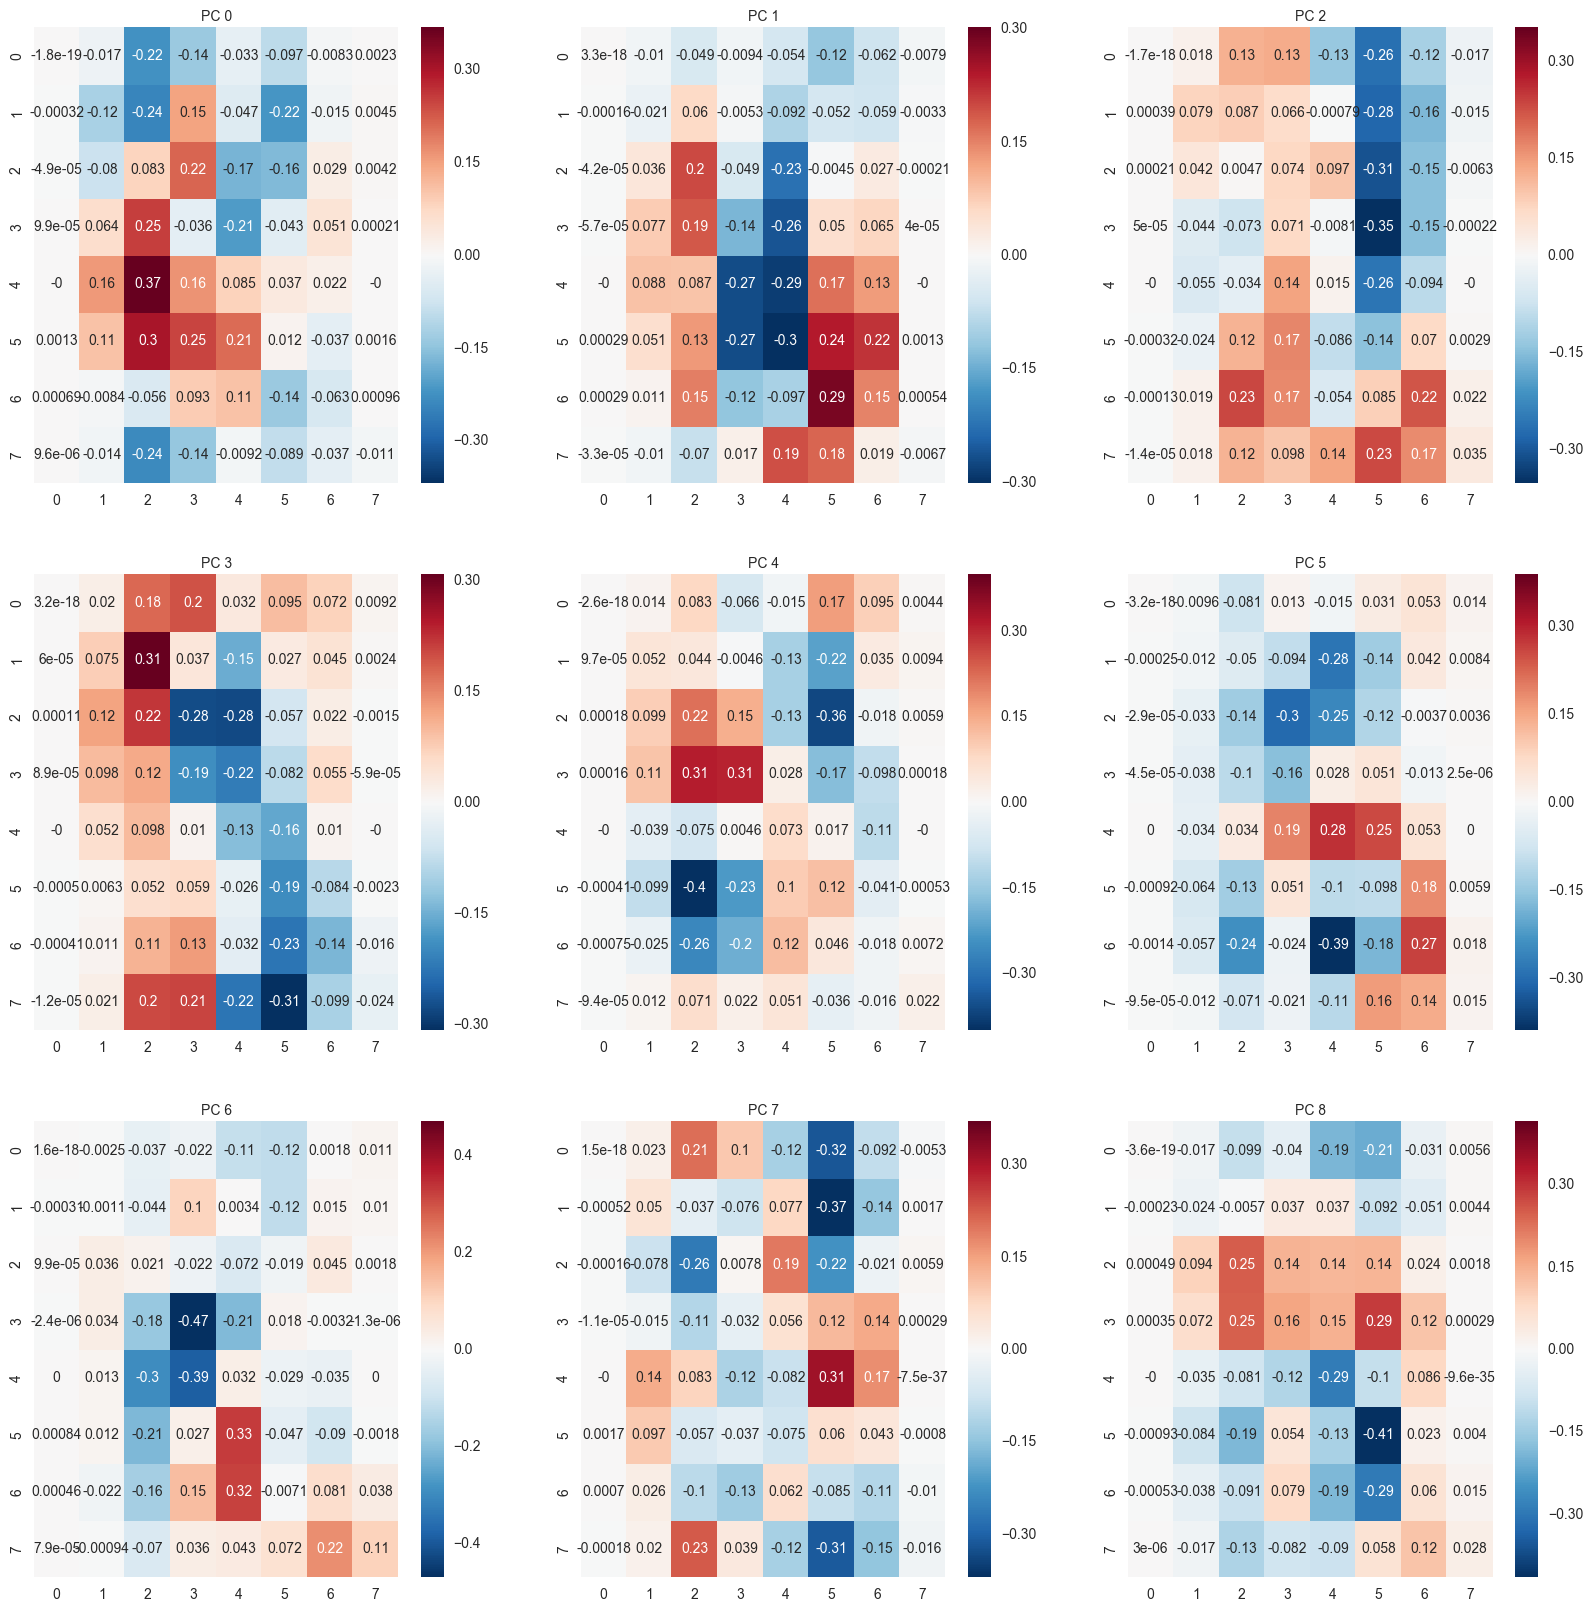

In [60]:
# Your code goes here
# First 9 principal components in the dataset
firstninePC = pca.components_[0:9,:]

fig, axs = plt.subplots(nrows=3, ncols=3,figsize=(20, 20))

axs = axs.ravel() #axs reshape to 1D array
for i in range(len(axs)): #axs reshape to 1D array
    axs[i].set_title('PC '+str(i),fontsize=10)
    plotdigit = firstninePC[i]
    axs[i] = sns.heatmap(plotdigit.reshape(8,8),annot=True,ax=axs[i])

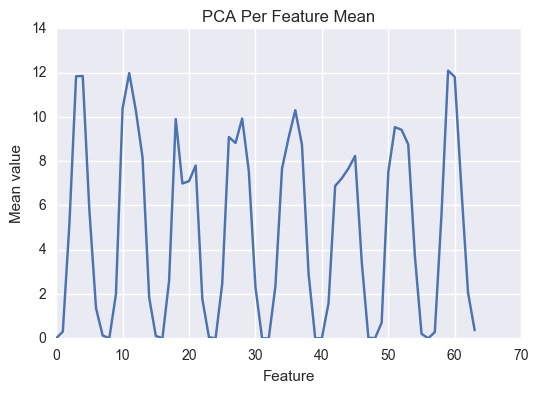

In [61]:
# Per Feature Mean
plt.title('PCA Per Feature Mean')
plt.xlabel('Feature')
plt.ylabel('Mean value')
plt.plot(pca.mean_)
plt.show()

### ========== Question 2.4 ==========

Now we want to make clear how these eigenvectors and the mean are used to approximate the data. `pca.transform(digits.data[idx,:].reshape(1, -1)).flatten()` will transform the digit in row `idx` into pca space. Another way to think about this is that it will give you the coefficents to multiply each eigenvector by and to add to the mean digit such that you can reconstruct the digit.

For the digit with idx = 0 (which should itself be a zero), create 4 plots:
1. The original digit
1. The digit reconstructed using 1 principal component
1. The digit reconstructed using 2 principal components
1. The digit reconstructed using 5 principal components

In the plot titles show:
1. the number of principal components used
1. the percentage of variance explained by that number of principal components
1. the coefficients of each principal component rounded to nearest integer (tip, convert to integers to reduce print space), i.e. the PCA space vector.

Below the plots, comment on the result. Do the eigenvectors produce realistic data?

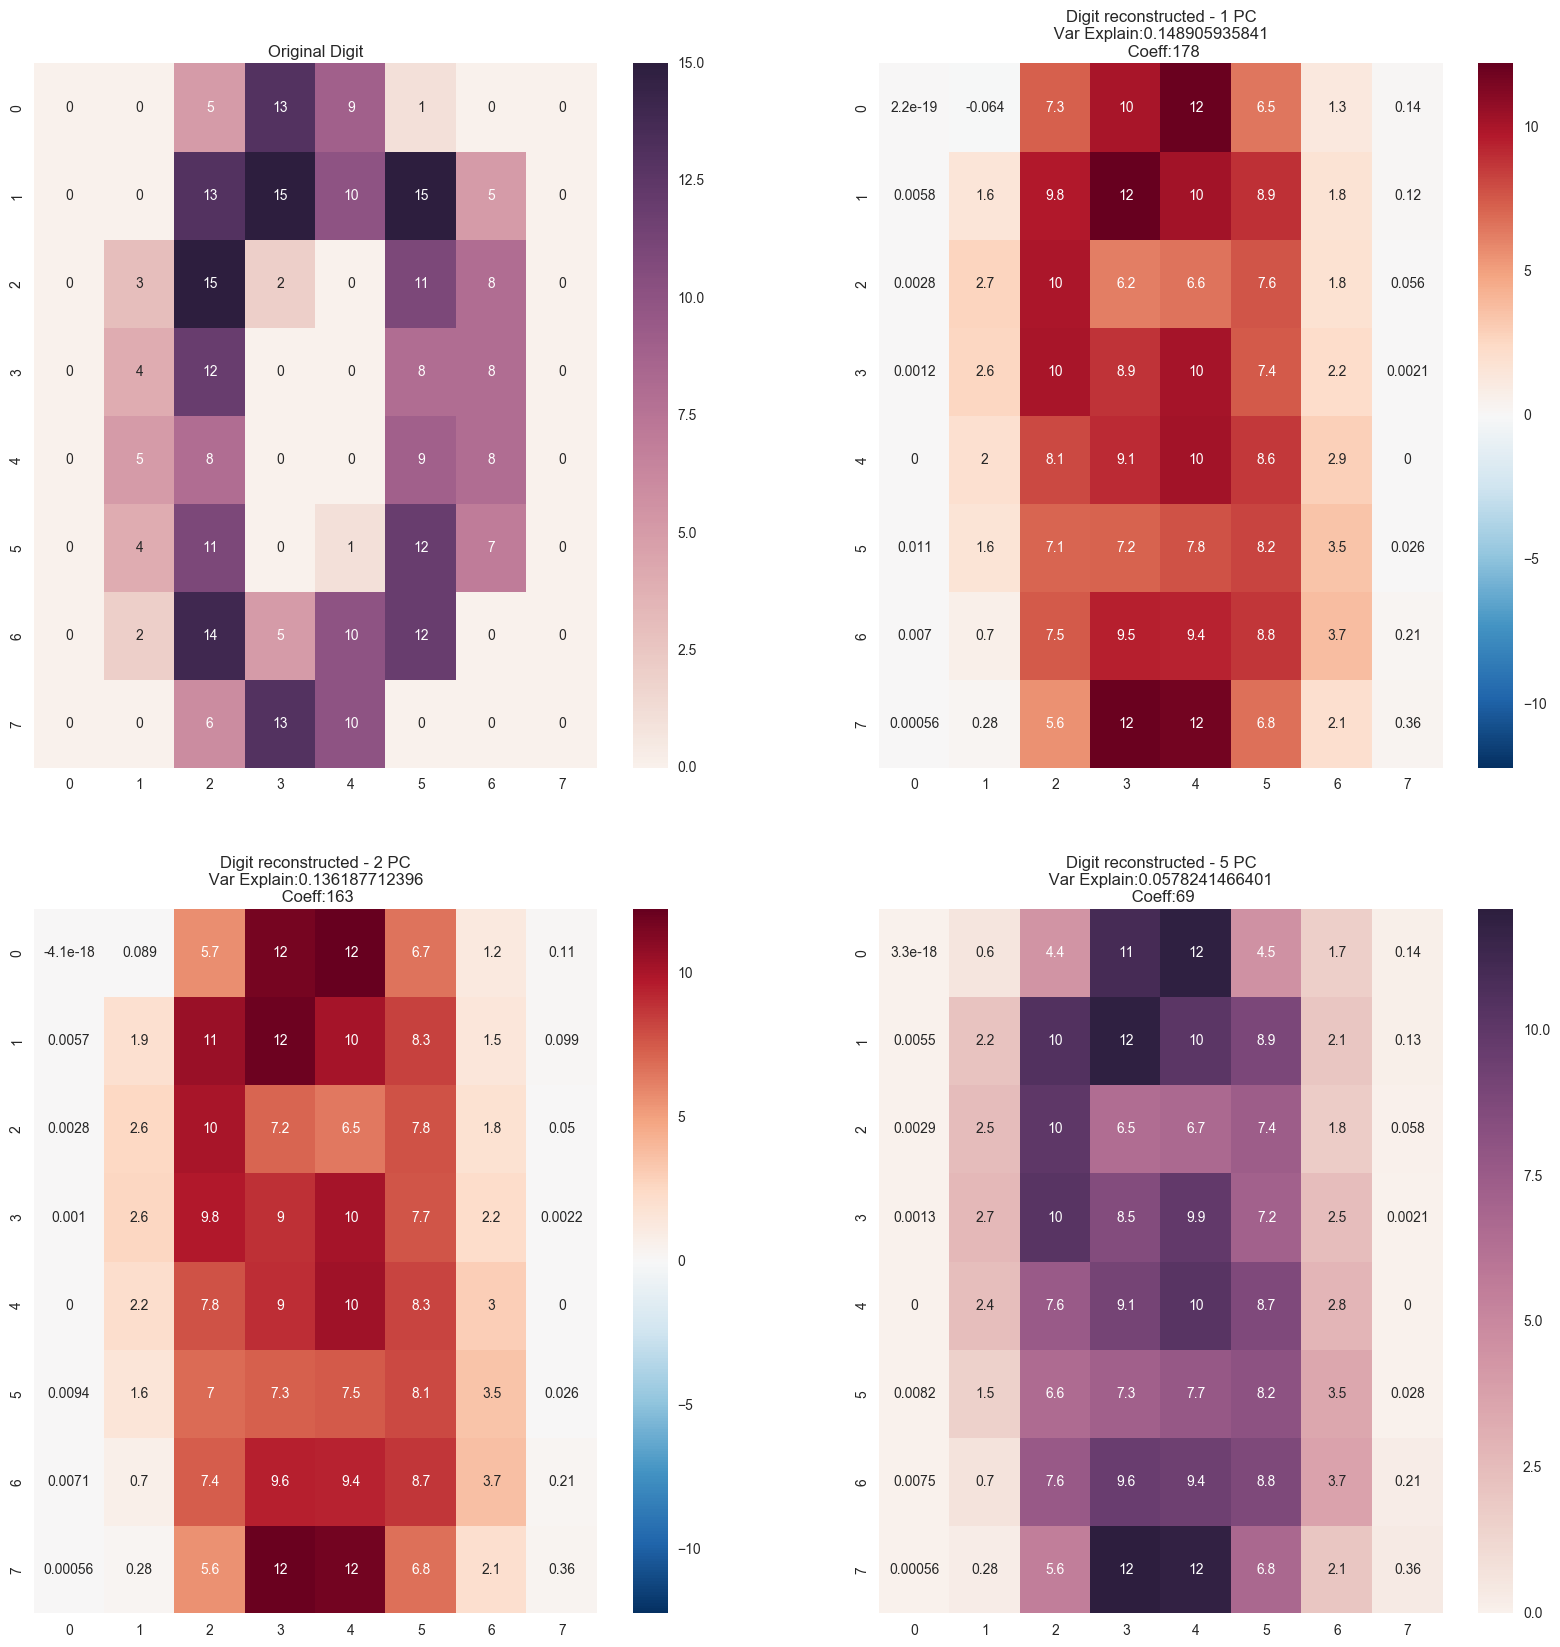

In [62]:
# Your code goes here
fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(20, 20))
axs = axs.ravel() #axs reshape to 1D array
trf = pca.transform(digits.data[0,:].reshape(1,-1)).flatten()
pc1 = pca.components_[0,:]# eigenvector of 1 principal component
pc2 = pca.components_[1,:] # eigenvector of 2 principal components
pc5 = pca.components_[4,:]# eigenvector of 1 principal components

# Original Digit
axs[0].set_title ('Original Digit')
axs[0] = sns.heatmap(digits.data[0,:].reshape(8,8),annot=True,ax=axs[0])

# Digit reconstructed - 1 principal component
digit_new = np.add(np.multiply(trf,pc1),pca.mean_)
pc1explain = pca.explained_variance_ratio_[0]
pc1coef = int(pca.explained_variance_[0])
axs[1].set_title('Digit reconstructed - 1 PC\n Var Explain:{0} \n Coeff:{1}'.format(str(pc1explain),str(pc1coef),fontsize=10))
axs[1] = sns.heatmap(digit_new.reshape(8,8),annot=True,ax=axs[1])

# Digit reconstructed - 2 principal components
digit_new = np.add(np.multiply(trf,pc2),pca.mean_)
pc2explain = pca.explained_variance_ratio_[1]
pc2coef = int(pca.explained_variance_[1])
axs[2].set_title('Digit reconstructed - 2 PC\n Var Explain:{0} \n Coeff:{1}'.format(str(pc2explain),str(pc2coef),fontsize=10))
axs[2] = sns.heatmap(digit_new.reshape(8,8),annot=True,ax=axs[2])

# Digit reconstructed - 5 principal components
digit_new = np.add(np.multiply(trf,pc5),pca.mean_)
pc5explain = pca.explained_variance_ratio_[4]
pc5coef = int(pca.explained_variance_[4])
axs[3].set_title('Digit reconstructed - 5 PC\n Var Explain:{0} \n Coeff:{1}'.format(str(pc5explain),str(pc5coef),fontsize=10))
axs[3] = sns.heatmap(digit_new.reshape(8,8),annot=True,ax=axs[3])


*Your answer goes here*

In this case (since we know the optimal number of principal components is 29), we can see that the heatmap is still not represent the original digit. But it do improve as more principal components used, thus implies the eigenvectors (principal components) produce realistic data.

### ========== Question 2.5 ==========

**Challenge question** 

Fit 4 models:
1. SVC with a linear kernel, no shrinking, and a random_state on digit data
1. SVC with a linear kernel, no shrinking, and the same random_state on pca transformed digit data (use the full 64 component pca above)
1. Gaussian Naive Bayes Classifier on digit data
1. Gaussian Naive Bayes Classifier on pca transformed digit data (use the full 64 component pca above)

Use 5 fold cross validation and take the mean fold score as the result. Plot or print the results.

Below the code, explain why one classifier improved but the other did not!

In [63]:
# Your code goes here

# Data preparation
X = digits.data
y = digits.target

# PCA transform
pca = PCA(n_components=digits.data.shape[1], random_state=1511)
Xtrf = pca.fit_transform(digits.data)

# Iterator
kf = KFold(X.shape[0],n_folds=5,shuffle=True,random_state=0)

In [64]:
# SVC Linear - Original Data
svc = SVC(kernel='linear',shrinking=False,random_state=1511,probability=True)
acc_array=[]   
logloss_array=[]

for train_index,test_index in kf :
    X_train,X_test = X[train_index],X[test_index]
    y_train,y_test = y[train_index],y[test_index]
    svc.fit(X_train,y_train)
    acc_array.append(svc.score(X_test,y_test)) # score based on test data
    logloss_array.append(log_loss(y_test,svc.predict_proba(X_test)))
    
mean_acc =  np.mean(acc_array, axis=0)
mean_logloss =  np.mean(logloss_array, axis=0)

print('Score based on test set, represent the mean value across 5 folds')
print('Linear SVC classification accuracy : {:.3f}'.format(mean_acc))
print('Linear SVC log loss: {:.3f}'.format(mean_logloss))

Score based on test set, represent the mean value across 5 folds
Linear SVC classification accuracy : 0.984
Linear SVC log loss: 0.108


In [65]:
# SVC Linear - PCA Transformed 
svctrf = SVC(kernel='linear',shrinking=False,random_state=1511,probability=True)
acc_array=[]   
logloss_array=[]

for train_index,test_index in kf :
    X_train,X_test = Xtrf[train_index],Xtrf[test_index]
    y_train,y_test = y[train_index],y[test_index]
    svctrf.fit(X_train,y_train)
    acc_array.append(svctrf.score(X_test,y_test)) # score based on test data
    logloss_array.append(log_loss(y_test,svctrf.predict_proba(X_test)))
    
mean_acc =  np.mean(acc_array, axis=0)
mean_logloss =  np.mean(logloss_array, axis=0)

print('Score based on test set, represent the mean value across 5 folds')
print('Linear SVC classification accuracy : {:.3f}'.format(mean_acc))
print('Linear SVC log loss: {:.3f}'.format(mean_logloss))

Score based on test set, represent the mean value across 5 folds
Linear SVC classification accuracy : 0.984
Linear SVC log loss: 0.108


In [66]:
# Gaussian Naive Bayes - Original Data
clf_gauss = GaussianNB()
acc_array=[]   
logloss_array=[]

for train_index,test_index in kf :
    X_train,X_test = X[train_index],X[test_index]
    y_train,y_test = y[train_index],y[test_index]
    clf_gauss.fit(X_train,y_train)
    acc_array.append(clf_gauss.score(X_test,y_test)) # score based on test data
    logloss_array.append(log_loss(y_test,clf_gauss.predict_proba(X_test)))
    
mean_acc =  np.mean(acc_array, axis=0)
mean_logloss =  np.mean(logloss_array, axis=0)

print('Score based on test set, represent the mean value across 5 folds')
print('Linear SVC classification accuracy : {:.3f}'.format(mean_acc))
print('Linear SVC log loss: {:.3f}'.format(mean_logloss))

Score based on test set, represent the mean value across 5 folds
Linear SVC classification accuracy : 0.834
Linear SVC log loss: 2.792


In [67]:
# Gaussian Naive Bayes - PCA Transformed
clf_gausstrf = GaussianNB()
acc_array=[]   
logloss_array=[]

for train_index,test_index in kf :
    X_train,X_test = Xtrf[train_index],Xtrf[test_index]
    y_train,y_test = y[train_index],y[test_index]
    clf_gausstrf.fit(X_train,y_train)
    acc_array.append(clf_gausstrf.score(X_test,y_test)) # score based on test data
    logloss_array.append(log_loss(y_test,clf_gausstrf.predict_proba(X_test)))
    
mean_acc =  np.mean(acc_array, axis=0)
mean_logloss =  np.mean(logloss_array, axis=0)

print('Score based on test set, represent the mean value across 5 folds')
print('Linear SVC classification accuracy : {:.3f}'.format(mean_acc))
print('Linear SVC log loss: {:.3f}'.format(mean_logloss))

Score based on test set, represent the mean value across 5 folds
Linear SVC classification accuracy : 0.889
Linear SVC log loss: 0.958


*Your answer goes here*

Gaussian Naive Bayes improved since the reduction in dimensionality means less features, thus will 'reduce' our 'naive' assumption that each feature is independence to others. 

SVM performance is the same due to the reduction in dimensionality will not change the decision boundary since the distance between the decision boundary and the closest training point (or the margin) will not change as well.